# 3D-BPP

## Pre-requisites

In [4]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import sys
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

sys.path.append('src/')
import config, dataset, main, utils, bins


<IPython.core.display.Javascript object>

In [5]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [6]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [7]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


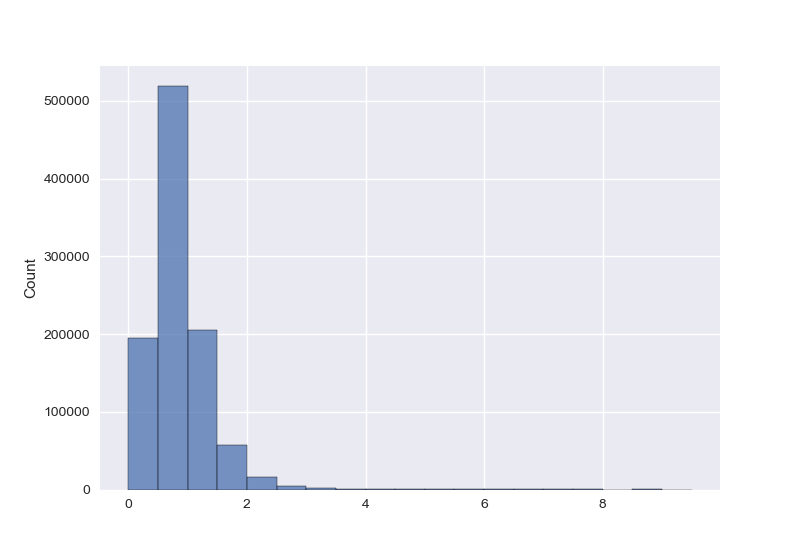

<IPython.core.display.Javascript object>

In [8]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


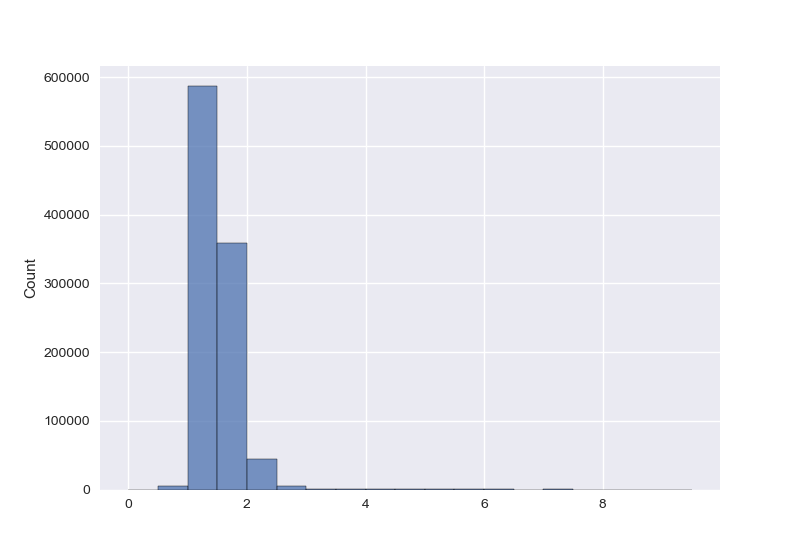

<IPython.core.display.Javascript object>

In [9]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


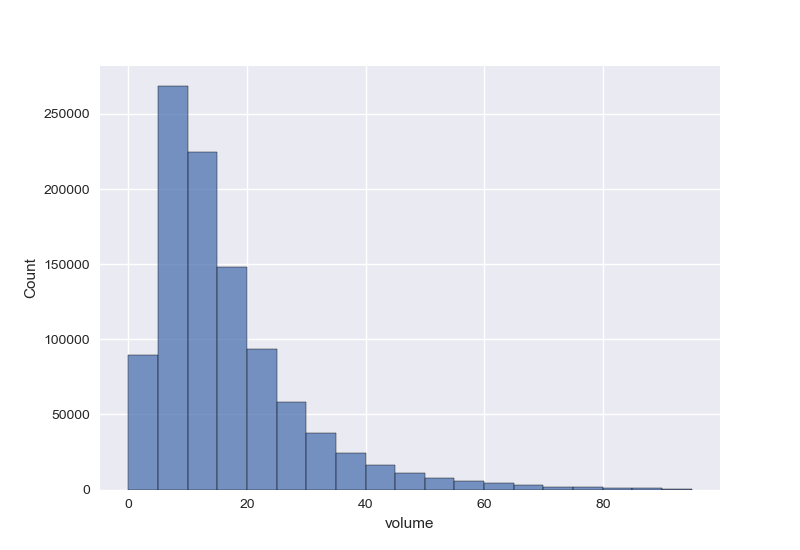

<IPython.core.display.Javascript object>

In [10]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


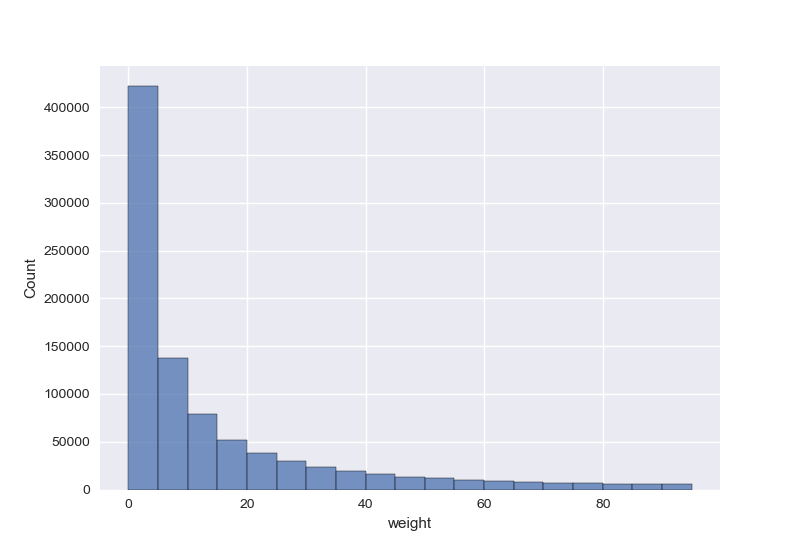

<IPython.core.display.Javascript object>

In [11]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


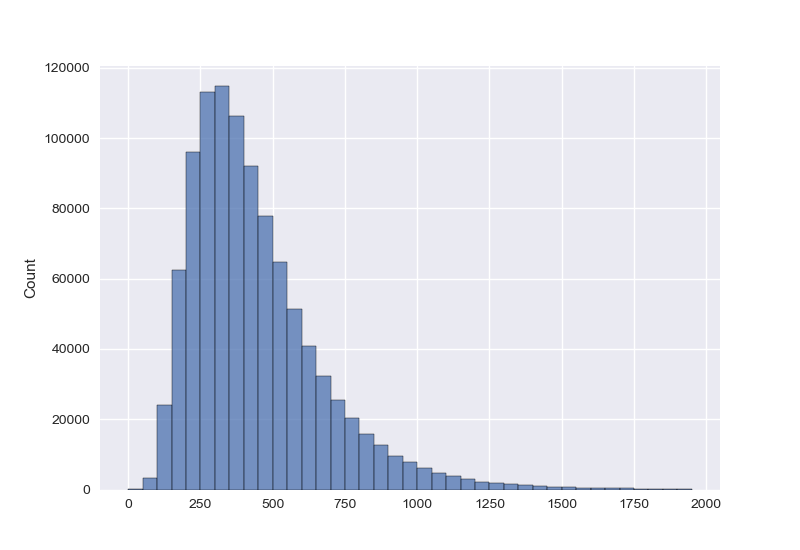

<IPython.core.display.Javascript object>

In [12]:
plt.figure()
sns.histplot(
    product_dataset.products.width * product_dataset.products.depth / 100,
    bins=np.arange(0, 2000, 50),
)
plt.show()

### Order

In [13]:
ordered_products = 50
order = product_dataset.get_order(ordered_products)
# order = product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [68]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [69]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [70]:
utils.get_l2_lb(order, config.PALLET_DIMS)

2500it [00:10, 231.49it/s]
2450it [00:10, 233.15it/s]
2450it [00:10, 234.02it/s]


(1.0, 1.0, 1.0, 1.0)

<IPython.core.display.Javascript object>

## Baseline

In [11]:
bl_layer_pool = main.baseline_procedure(order)
bl_layer_pool.to_dataframe()

Generating vertical superitems: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Items not covered: 0/10


,item,x,y,z,width,depth,height,layer
0,0,353,0,0,343,263,411,0
1,1,0,0,0,294,136,440,0
2,2,0,136,0,180,57,234,0
3,3,0,193,0,176,100,225,0
4,4,180,136,0,173,179,248,0
5,5,0,315,0,202,210,349,0
6,6,0,525,0,366,256,654,0
7,7,366,263,0,277,192,416,0
8,8,643,263,0,286,162,450,0
9,9,929,0,0,249,237,318,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


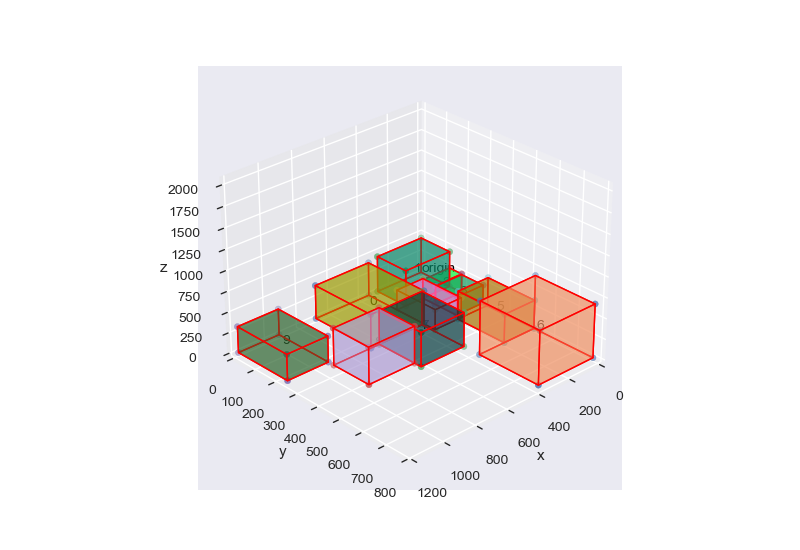

<IPython.core.display.Javascript object>

In [12]:
bl_bin_pool = bins.BinPool(bl_layer_pool, config.PALLET_DIMS)
bl_bin_pool.plot()

## Maxrects

In [15]:
mr_layer_pool = main.maxrects_procedure(order)
mr_layer_pool.to_dataframe()

2021-07-30 15:39:48.920 | INFO     | main:maxrects_procedure:132 - Maxrects iteration 1/1
Generating vertical superitems: 100%|██████████████████████████████████████████████████████████████| 14/14 [00:00<?, ?it/s]
2021-07-30 15:39:48.964 | INFO     | main:maxrects_warm_start:42 - Computing warm start layers
2021-07-30 15:39:48.989 | INFO     | main:maxrects_warm_start:55 - Identified 0 layers in warm start
2021-07-30 15:39:48.995 | INFO     | main:maxrects_procedure:160 - Items not covered: 50/50


Generated 0
Density 0
Coverage 0
Duplicates 0
Empty 0


""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


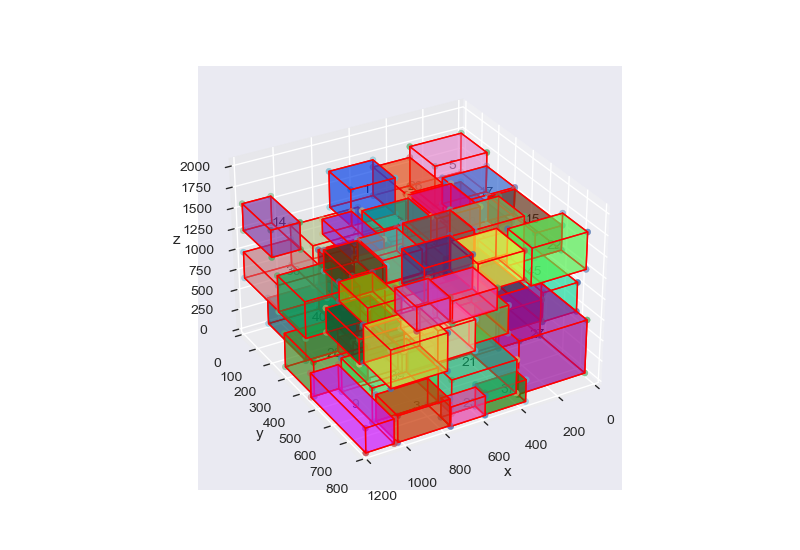

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [16]:
mr_bin_pool = bins.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

## Column generation

In [17]:
filtered_cg_layer_pool, cg_layer_pool, cg_bins_lbs = main.column_generation_procedure(
    order, use_height_groups=False
)
filtered_cg_layer_pool.to_dataframe()

2021-07-30 15:44:06.432 | INFO     | main:column_generation_procedure:206 - Processing height group 1/1
2021-07-30 15:44:06.434 | INFO     | main:maxrects_warm_start:42 - Computing warm start layers
2021-07-30 15:44:06.436 | INFO     | main:maxrects_warm_start:55 - Identified 0 layers in warm start
2021-07-30 15:44:06.620 | INFO     | main:column_generation_procedure:242 - Items not covered: 50/50


Iteration 1/100
Solving RMP...
ERROR-----Unfeasible main problem--------
Generated 0
Density 0
Coverage 0
Duplicates 0
Empty 0


ValueError: not enough values to unpack (expected 3, got 2)

<IPython.core.display.Javascript object>

In [ ]:
for i, l in enumerate(cg_layer_pool):
    display(l.to_dataframe())
    print(i)

In [139]:
cg_layer_pool[39].superitems_pool.to_dataframe()

,width,depth,height,ids,type
0,352,259,457,[5],SingleItemSuperitem
1,345,191,446,[0],SingleItemSuperitem
2,345,191,845,"[0, 6]",VerticalSuperitem
3,378,126,489,[9],SingleItemSuperitem
4,330,191,399,[6],SingleItemSuperitem
5,210,182,324,[4],SingleItemSuperitem
6,149,165,246,[16],SingleItemSuperitem
7,135,165,198,[19],SingleItemSuperitem
8,190,181,285,[1],SingleItemSuperitem
9,154,142,266,[13],SingleItemSuperitem


<IPython.core.display.Javascript object>

In [134]:
zsl = cg_layer_pool.get_zsl()[:, 39]

<IPython.core.display.Javascript object>

In [138]:
fsi, _, _ = cg_layer_pool.superitems_pool.get_fsi()
print(fsi.shape)

(31, 20)


<IPython.core.display.Javascript object>

In [140]:
for i in range(20):
    print(sum([fsi[s, i] * zsl[s] for s in range(31)]) <= 1)

False
True
True
True
True
True
False
False
False
True
True
False
False
True
True
True
False
True
True
False


<IPython.core.display.Javascript object>

In [75]:
filtered_cg_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,23,0,0,0,228,379,354,0
1,42,0,379,0,228,316,363,0
2,44,0,695,0,212,96,331,0
3,10,228,0,0,254,208,346,0
4,7,482,0,0,270,183,365,0
5,0,752,0,0,229,214,367,0
6,1,482,183,0,257,167,355,0
7,38,228,208,0,223,191,316,0
8,31,981,0,0,203,192,339,0
9,48,981,192,0,135,280,302,0


<IPython.core.display.Javascript object>

In [40]:
print(filtered_cg_layer_pool.get_densities(two_dims=False))
print(filtered_cg_layer_pool.get_densities(two_dims=True))

[0.6724938890515223]
[0.855096875]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


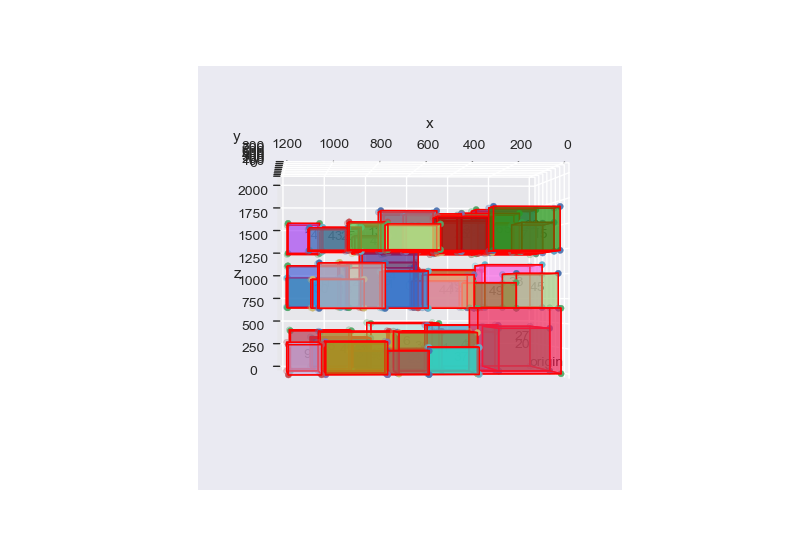

[<Axes3DSubplot:xlabel='x', ylabel='y'>]

<IPython.core.display.Javascript object>

In [10]:
cg_bin_pool = bins.BinPool(filtered_cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

In [ ]:
np.floor(np.mean(cg_bins_lbs) / config.PALLET_HEIGHT)

## Comparison

In [11]:
print("\tCG")
print("Bin Heights:", cg_bin_pool.get_heights())
print()
print("Bin Densities:", cg_bin_pool.get_bin_densities())
print()
print("Layer Densities:", cg_bin_pool.get_layer_densities(two_dims=False))
print()
print("\tMR")
print("Bin Heights:", mr_bin_pool.get_heights())
print()
print("Bin Densities:", mr_bin_pool.get_bin_densities())
print()
print("Layer Densities:", mr_layer_pool.get_densities(two_dims=False))

	CG
Bin Heights: [1715]

Bin Densities: [0.45399603862530413]

Layer Densities: [[0.5825106731014271, 0.5504133117816092, 0.48390885308385306]]

	MR
Bin Heights: [1840]

Bin Densities: [0.45399603862530413]

Layer Densities: [0.742000318877551, 0.5062176748294347, 0.41996953577336643, 0.40269961932976556]


<IPython.core.display.Javascript object>